## Imports

In [1]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marileonhardsen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer # For sentiment analysis
import pickle # For loaded dataset from pickle file
import tqdm # Progress bar
from collections import Counter # Handy addon
from pprint import pprint # Useful to print JSON objects
import numpy as np

In [7]:
# This loads the file that you want, might take several seconds (up to a minute)

with open("news_sentiment.pickle", "rb") as f:
    articles = pickle.load(f, encoding='bytes')
print(len(articles), "articles were loaded")

57767 articles were loaded


In [8]:
# separate articles from the two stories
ISIS_articles = []
Brexit_articles = []
for a in articles:
    if a[b"news_topic"] == b'ISIS War':
        ISIS_articles.append(a)
    else:
        Brexit_articles.append(a)
        
print(len(ISIS_articles), " articles from ISIS War and ", len(Brexit_articles), "articles from Brexit were loaded")

39206  articles from ISIS War and  18561 articles from Brexit were loaded


In [9]:
# get only articles from one story, you can change this
articles = Brexit_articles

## Extract introductions, and obtain their sentiment

In [10]:
analyzer = SentimentIntensityAnalyzer()

total_introductions = []
for a in articles:
    for intro in a.get('introductions', []):
        intro['source'] = a['source']
        total_introductions.append(intro)

for intro in tqdm.tqdm_notebook(total_introductions):
    intro['sentiment'] = analyzer.polarity_scores(intro['text'])['compound']

A Jupyter Widget

In [12]:
# Example some sentiment for some of the introductions

subsample = np.random.choice(total_introductions, 100)
for intro in subsample:
    if intro['sentiment'] != 0:
        print("---------------")
        print("Entity mentionned:", intro['person'])
        print(intro['text'])
        print("Sentiment:", intro['sentiment'])

---------------
Entity mentionned: Richard Lochhead
the former Rural Affairs Minister at the centre of the EU farm payments scandal
Sentiment: -0.4404
---------------
Entity mentionned: Russell Brand
the comedian
Sentiment: 0.3818
---------------
Entity mentionned: Ed Miliband
Britain 's Labour Party leader
Sentiment: 0.4019
---------------
Entity mentionned: Husam Zomlot
a holocaust denier who have previously suggested that Israel had " fabricated " the fact Isil is beheading journalists
Sentiment: -0.3612
---------------
Entity mentionned: Jeremy Corbyn
the leader of the opposition Labour Party
Sentiment: 0.4019
---------------
Entity mentionned: Theresa May
the party 's nationwide leader , , whose future is now in question
Sentiment: 0.4019
---------------
Entity mentionned: Jeremy Corbyn
opposition Labour party Leader
Sentiment: 0.4019
---------------
Entity mentionned: David Cameron
worried
Sentiment: -0.296
---------------
Entity mentionned: Hutchings
a mother of four and spiritu

## Build a 2-dimensional object containing sentiment per entity, per source

In [13]:
ent_source_sent = {}

for intro in total_introductions:
    p = intro['person']
    s = intro['source']
    if p not in ent_source_sent:
        ent_source_sent[p] = {}
    if s not in ent_source_sent[p]:
        ent_source_sent[p][s] = []
    ent_source_sent[p][s].append(intro['sentiment'])

In [14]:
# An example of how one entity (a city) is described by different sources
print(ent_source_sent['Theresa May'])

{'chinadaily.com.cn': [0.0, 0.0, 0.0, 0.0, 0.0, -0.128, 0.0258, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'france24.com': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.4588, 0.0, 0.0, 0.0, 0.0, -0.1531, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.128, 0.0, 0.0, 0.5267, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2732, -0.128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [15]:
# We get rid of entities that don't contain enough data

entities_kept = []

for entity in ent_source_sent.keys():
    sentiments = ent_source_sent[entity]
    total_size = sum([len(sentiments[source]) for source in sentiments.keys()])
    if total_size >= 3:
        entities_kept.append(entity)
        
print("We will keep a total of", len(entities_kept), " / ", len(ent_source_sent.keys()) ,"in our dataset")

sources = set([])
for entity in entities_kept:
    sources|= set(ent_source_sent[entity].keys())
sources = list(sources)

print("We have ", len(sources), "sources: ", sources)

We will keep a total of 4525  /  13497 in our dataset
We have  22 sources:  ['latimes.com', 'wikinews.org', 'reuters.com', 'businessinsider.in', 'cnn.com', 'nytimes.com', 'aa.com.tr', 'rt.com', 'middleeasteye.net', 'chinadaily.com.cn', 'bloomberg.com', 'theguardian.com', 'techcrunch.com', 'aljazeera.com', 'washingtonpost.com', 'ap.org', 'foxnews.com', 'allafrica.com', 'telegraph.co.uk', 'independent.co.uk', 'france24.com', 'bbc.co.uk']


## We create the array we will use in our sparse model

In [16]:
# Parameters: changing these affects the results you get
Pos_neg_ratio = 2.0
overall_ratio = 0.15
pos_threshold = 0.15
neg_threshold = -0.15

N = len(entities_kept)
M = len(sources)
A = np.zeros((N, M))
z_score_thresh = 2

sentiment_counts = Counter()

source2j = {source: j for j, source in enumerate(sources)}

for i, entity in enumerate(entities_kept):
    for source in ent_source_sent[entity].keys():
        sent_array = np.array(ent_source_sent[entity][source])
        N_pos = float(len(np.where(sent_array > pos_threshold)[0]))
        N_neg = float(len(np.where(sent_array < neg_threshold)[0]))
        T = float(len(sent_array))
        aggregate_sentiment = 0
        if N_pos > Pos_neg_ratio*N_neg and N_pos > overall_ratio*T:
            aggregate_sentiment = 1
        elif N_neg > Pos_neg_ratio*N_pos and N_neg > overall_ratio*T:
            aggregate_sentiment = -1
        j = source2j[source]
        
        A[i,j] = aggregate_sentiment
        
        sentiment_counts[aggregate_sentiment] += 1

print ("We allocated some sentiment in this matrix, the repartition is:", sentiment_counts)

We allocated some sentiment in this matrix, the repartition is: Counter({0: 10028, 1: 2305, -1: 764})


## Model source similarity

In [17]:
# Write code that uses this matrix (entities, sources) to compute
# source similarity visible in bias of the way they describe entities

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, SparsePCA
A_std = StandardScaler().fit_transform(A)

## Workspace

In [19]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [20]:
from Visualizer import plot_network 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

In [21]:
#Import implemented algorithms
from NeighborhoodGraphSelection import NGraphSelection
from sklearn.linear_model import Lasso
from Lasso import Lasso2

## PCA transformed matrix

In [22]:
#Obtain PCA transformed data matrix 
pca = PCA()
B = pca.fit_transform(A.T).T
B_std = StandardScaler().fit_transform(B)

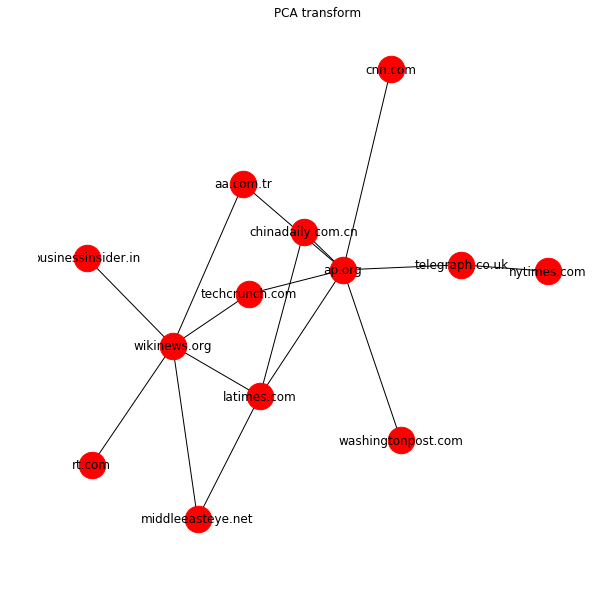

In [33]:
nbh = NGraphSelection(Lasso2)
g = nbh.fit(B_std, 0.17, 'AND')
plot_network(g, sources, "PCA transform", "PCA_transform")

## Sparse PCA transform

In [59]:
#Obtain spare PCA transformed data matrix 
sparse_pca = SparsePCA(n_components = 100, alpha = 2.0)
C = sparse_pca.fit_transform(A.T).T
C_std = StandardScaler().fit_transform(C)

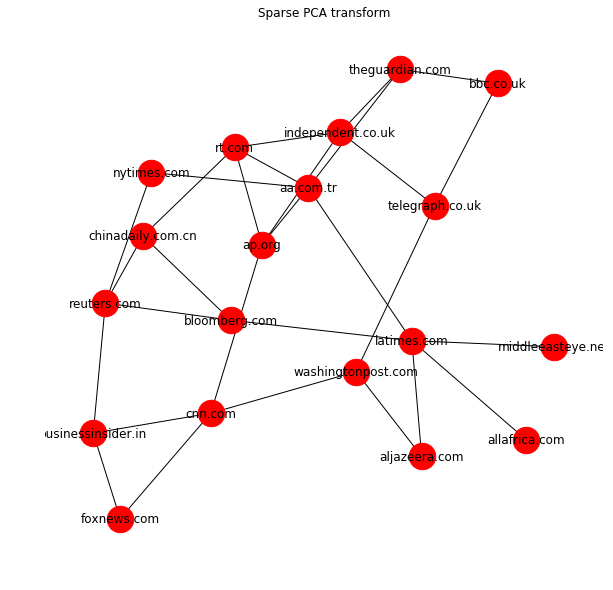

In [61]:
nbh = NGraphSelection(Lasso2)
g = nbh.fit(C_std, 0.2, 'AND')
plot_network(g, sources, "Sparse PCA transform", "SPCA_transform")

## Data reduction by top important actors

In [39]:
sparse_pca = SparsePCA(n_components = 15, alpha=1.3)
sparse_pca.fit(A.T)

SparsePCA(U_init=None, V_init=None, alpha=1.3, max_iter=1000, method='lars',
     n_components=15, n_jobs=1, random_state=None, ridge_alpha=0.01,
     tol=1e-08, verbose=False)

In [40]:
#extract actors of most importance
mask= np.zeros_like(sparse_pca.components_[0], dtype = bool)
for component in sparse_pca.components_ : 
    for i in range(len(component)):
        if component[i] != 0:
            mask[i] = True
D = A[mask, :]
print(D.shape)

(131, 22)


In [41]:
D_std = StandardScaler().fit_transform(D)

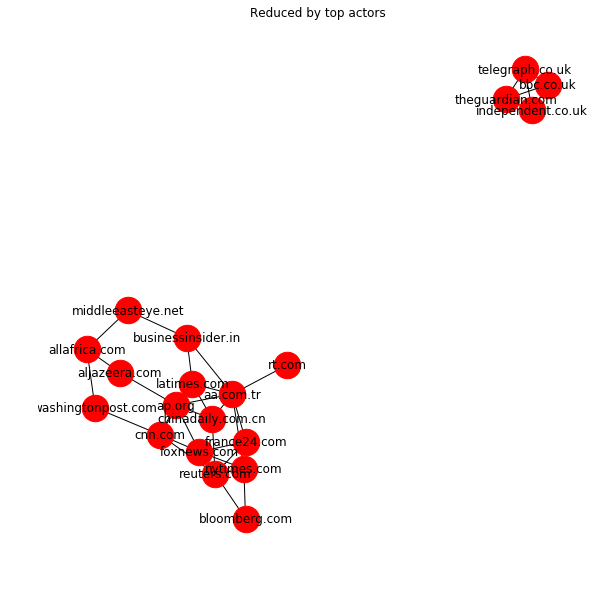

In [43]:
nbh = NGraphSelection(Lasso2)
g = nbh.fit(D_std, 0.21, 'AND')
plot_network(g, sources, "Reduced by top actors", "Red_top_act")

## Relationship between actors 

In [44]:
sparse_pca = SparsePCA(n_components = 3, alpha=2.0)
sparse_pca.fit(A.T)

SparsePCA(U_init=None, V_init=None, alpha=2.0, max_iter=1000, method='lars',
     n_components=3, n_jobs=1, random_state=None, ridge_alpha=0.01,
     tol=1e-08, verbose=False)

In [45]:
#extract actors
mask= np.zeros_like(sparse_pca.components_[0], dtype = bool)
for component in sparse_pca.components_ : 
    for i in range(len(component)):
        if component[i] != 0:
            mask[i] = True
E = A[mask, :].T
print(E.shape)
E_std = StandardScaler().fit_transform(E)

(22, 18)


In [46]:
#identify relevant actors
print(len(mask))
print(len(entities_kept))
sparse_entities = [entities_kept[i] for i in range(len(entities_kept)) if mask[i]]
print(sparse_entities)

4525
4525
['Jeremy Corbyn', 'Paul Nuttall', 'Nigel Farage', 'Dominic Raab', 'Chuka Umunna', 'Andrea Leadsom', 'Ruth Davidson', 'Michael Gove', 'Ed Miliband', 'Keir Starmer', 'Grant Shapps', 'Alex Salmond', 'Natalie Bennett', 'Graham Brady', 'Arlene Foster', 'Manfred Weber', 'Richard Angell', 'David Neuberger']


In [47]:
n_sel = NGraphSelection(Lasso2)
g_ = n_sel.fit(E_std, 0.6, 'AND')

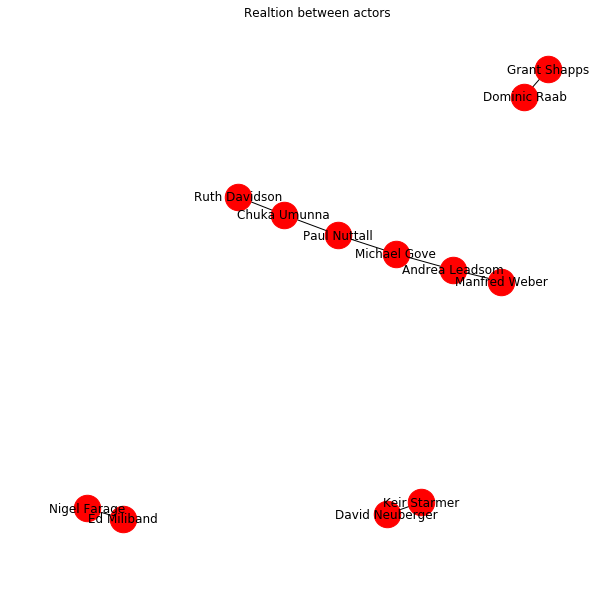

In [48]:
plot_network(g_, sparse_entities, "Realtion between actors", "Rel_bet_act")